GNN - I
=========================


In [ ]:
%matplotlib inline

Step 1: Creating a graph in DGL
-------------------------------
Create the graph for Zachary's karate club as follows:



In [1]:
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

Print out the number of nodes and edges in our newly constructed graph:



In [2]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


Visualize the graph by converting it to a `networkx
<https://networkx.github.io/documentation/stable/>`_ graph:



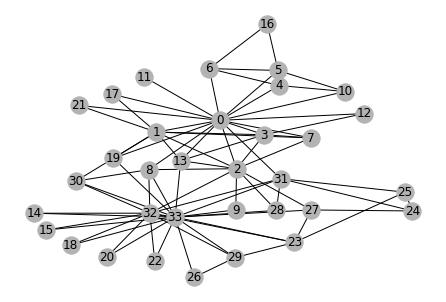

In [3]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

Step 2: Assign features to nodes or edges
--------------------------------------------
Graph neural networks associate features with nodes and edges for training.
For our classification example, since there is no input feature, we assign each node
with a learnable embedding vector.



In [4]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

Print out the node features to verify:



In [5]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 1.6222, -1.0475, -0.7552, -1.2638, -1.6311], grad_fn=<SelectBackward>)
tensor([[-0.8983,  0.8866,  0.9813,  1.8028,  0.3265],
        [-0.3356,  0.9923, -0.1266, -0.7830,  1.1100]],
       grad_fn=<IndexBackward>)


Step 3: Define a Graph Convolutional Network (GCN)
--------------------------------------------------
To perform node classification, use the Graph Convolutional Network
(GCN) developed by `Kipf and Welling <https://arxiv.org/abs/1609.02907>`_. Here
is the simplest definition of a GCN framework. We recommend that you 
read the original paper for more details.

- At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.
- Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where
  $u_i$'s are neighborhood nodes to $v$ into the next layer representation at
  $v_i^{l+1}$. This is followed by an affine transformation with some
  non-linearity.

The above definition of GCN fits into a **message-passing** paradigm: Each
node will update its own feature with information sent from neighboring
nodes. A graphical demonstration is displayed below.

![mailbox](https://data.dgl.ai/tutorial/1_first/mailbox.png)

In DGL, we provide implementations of popular Graph Neural Network layers under
the `dgl.<backend>.nn` subpackage. The :class:`~dgl.nn.pytorch.GraphConv` module
implements one Graph Convolutional layer.



In [10]:
from dgl.nn.pytorch import GraphConv

Define a deeper GCN model that contains two GCN layers:



In [11]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

Step 4: Data preparation and initialization
-------------------------------------------

We use learnable embeddings to initialize the node features. Since this is a
semi-supervised setting, only the instructor (node 0) and the club president
(node 33) are assigned labels. The implementation is available as follow.



In [12]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

Step 5: Train then visualize
----------------------------
The training loop is exactly the same as other PyTorch models.
We (1) create an optimizer, (2) feed the inputs to the model,
(3) calculate the loss and (4) use autograd to optimize the model.



In [13]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.8867
Epoch 1 | Loss: 0.8433
Epoch 2 | Loss: 0.8042
Epoch 3 | Loss: 0.7725
Epoch 4 | Loss: 0.7519
Epoch 5 | Loss: 0.7335
Epoch 6 | Loss: 0.7162
Epoch 7 | Loss: 0.7003
Epoch 8 | Loss: 0.6856
Epoch 9 | Loss: 0.6709
Epoch 10 | Loss: 0.6563
Epoch 11 | Loss: 0.6417
Epoch 12 | Loss: 0.6272
Epoch 13 | Loss: 0.6128
Epoch 14 | Loss: 0.5986
Epoch 15 | Loss: 0.5849
Epoch 16 | Loss: 0.5713
Epoch 17 | Loss: 0.5570
Epoch 18 | Loss: 0.5434
Epoch 19 | Loss: 0.5296
Epoch 20 | Loss: 0.5157
Epoch 21 | Loss: 0.5017
Epoch 22 | Loss: 0.4877
Epoch 23 | Loss: 0.4739
Epoch 24 | Loss: 0.4605
Epoch 25 | Loss: 0.4473
Epoch 26 | Loss: 0.4343
Epoch 27 | Loss: 0.4218
Epoch 28 | Loss: 0.4092
Epoch 29 | Loss: 0.3968
Epoch 30 | Loss: 0.3845
Epoch 31 | Loss: 0.3724
Epoch 32 | Loss: 0.3603
Epoch 33 | Loss: 0.3483
Epoch 34 | Loss: 0.3364
Epoch 35 | Loss: 0.3225
Epoch 36 | Loss: 0.3079
Epoch 37 | Loss: 0.2929
Epoch 38 | Loss: 0.2774
Epoch 39 | Loss: 0.2618
Epoch 40 | Loss: 0.2452
Epoch 41 | Loss: 0.2282
Ep

This is a rather toy example, so it does not even have a validation or test
set. Instead, Since the model produces an output feature of size 2 for each node, we can
visualize by plotting the output feature in a 2D space.
The following code animates the training process from initial guess
(where the nodes are not classified correctly at all) to the end
(where the nodes are linearly separable).



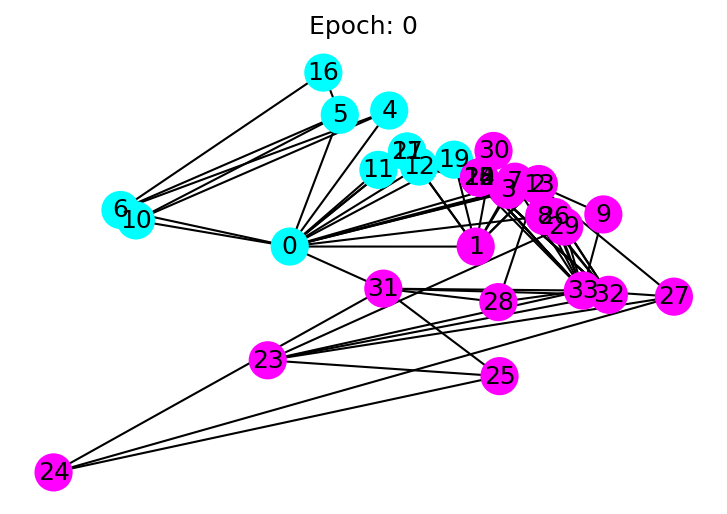

In [23]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
#plt.close()

In [20]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

![](https://data.dgl.ai/tutorial/1_first/karate.gif)
